# 選股策略

根據自定義的選股策略建立每期的10檔候選股票列表，以供後續ChatGPT虛擬助理處理

In [ ]:
sMdf.index = df_returns.index[1:]
date_stock_results = []
for index, row in sMdf.iterrows():
    top_n_stocks = row.nlargest(nk).index.tolist()
    date_stock_results.append([index, top_n_stocks])

df_stocks = pd.DataFrame(date_stock_results, columns=['日期', '股票']).set_index('日期')
print(df_stocks)

                                                           股票
日期                                                           
2023-08-30  [1338, 6213, 3057, 2402, 2436, 3715, 5225, 239...
2023-08-31  [2402, 4943, 2485, 2434, 3432, 1808, 1805, 649...
2023-09-01  [2236, 5215, 9919, 3588, 2204, 1802, 3167, 343...
2023-09-04  [6225, 2241, 6531, 2436, 2204, 1616, 5215, 301...
2023-09-05  [2358, 2614, 6412, 3043, 2816, 2401, 4961, 801...
...                                                       ...
2024-08-21  [2923, 2438, 6906, 1443, 1470, 2349, 8103, 643...
2024-08-22  [1711, 1512, 8438, 6405, 1721, 2429, 1708, 177...
2024-08-23  [4807, 2424, 3149, 5538, 8039, 2402, 3550, 246...
2024-08-26  [3040, 3515, 2399, 2425, 3605, 2424, 2465, 458...
2024-08-27  [8374, 4562, 8039, 4526, 4583, 2425, 4540, 242...

[242 rows x 1 columns]


## 投資策略1：直接依照選股策略得出之權重投資

<ipython-input-7-2ebb485d84b0>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p.append(sMdf1[t][i] * r1[i] * (s[i + 2] / 100 - fee_rate + 1))


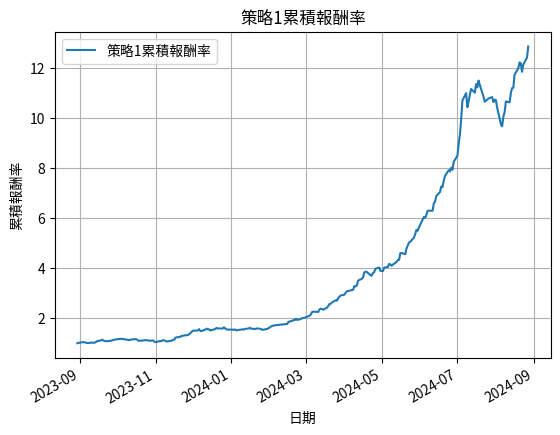

In [ ]:
sMdf1 = sMdf.copy()

l_new = sMdf1.sum(axis=1)
sMdf1 = sMdf1.div(l_new, axis='index')
r1 = [1.0]
for i in range(0, len(Mdf) - 1):
    p = []
    for t in df_returns.columns:
        s = df_returns[t]
        p.append(sMdf1[t][i] * r1[i] * (s[i + 2] / 100 - fee_rate + 1))
    r1.append(sum(p))

rdf1 = pd.DataFrame(r1, columns=['累積報酬率'])
rdf1.index = df_returns.index[1:]
rdf1['累積報酬率'].plot()
plt.title('策略1累積報酬率')
plt.xlabel('日期')
plt.ylabel('累積報酬率')
plt.legend(['策略1累積報酬率'])
plt.grid(True)
plt.show()

# 建立 GPT-4o mini 虛擬助理回傳風險評分
可自行更改提示詞與GPT模型

In [ ]:
class StockData:
    def __init__(self, merged_df):
        self.merged_df = merged_df

    def stock_price(self, stock_id, end_date, days):
        end_date = pd.to_datetime(end_date)
        start_date = end_date - timedelta(days=days)
        df_filtered = self.merged_df[(self.merged_df['股號'].isin(stock_id)) &
                                    (self.merged_df['日期'] >= start_date) &
                                    (self.merged_df['日期'] <= end_date)]
        if df_filtered.empty:
            return {}
        df_filtered = df_filtered.sort_values(by=['股號', '日期']).reset_index(drop=True)
        df_filtered['每日報酬'] = df_filtered.groupby('股號')['收盤價(元)'].pct_change()
        return df_filtered

class StockAnalysis2:
    def __init__(self, openai_api_key):
        self.client = openai.OpenAI(api_key=openai_api_key)

    def get_reply(self, messages):
        try:
            response = self.client.chat.completions.create(
                # 可自行更換模型
                model="gpt-4o-mini",
                temperature=0,
                messages=messages
            )
            reply = response.choices[0].message.content
            reply = reply.replace("dict", "").replace("'''", "").replace("```", "")
        except openai.OpenAIError as err:
            reply = f"發生 {err.type} 錯誤\n{err.message}"
        return reply

    def stock_sort(self, data):
        # 設定提示詞與使用者提問資料
        msg = [{
            "role": "system",
            "content":
            "你現在是一位專業的股票分析師，會根據各股的專業趨勢分析報告評斷，\
            包含股價走勢、籌碼面分析、技術面分析等，評斷各股適不適合投資，給予0-100之間的風險評分。\n\
            以50分為基準,以判斷投資風險大小為重點，風險大須提高風險評分，風險小則減少風險評分。\
            最後請將所有股票與評分以字典顯示，回答格式必須為dict，key是股號、value是分數，格式必須按照:\n\
            {'0000':50,'0001':60}。只能回答dict，不可有多餘訊息。"
        }, {
            "role": "user",
            "content": str(data)
        }]
        reply_data = self.get_reply(msg)
        return reply_data

# 透過getpass輸入API金鑰
openai_api_key = getpass.getpass("請輸入 openai API 金鑰：")
six2 = StockAnalysis2(openai_api_key)
stock_data = StockData(merged_df)

請輸入 openai API 金鑰：··········


依照選股策略選出的股票清單，逐期對虛擬助理進行提問。
將回答結果儲存在雲端，方便初步排除錯誤與修改，同時避免重複進行問答，浪費API額度。

In [ ]:
d =  # 期數設定，會將d+1天之股票歷史資料給虛擬助理作為評分參考

# 自訂回答結果保存路徑，預設為雲端硬碟最外層
file_path = '/content/drive/MyDrive/GPT_scores.csv'

def check_and_load_existing_data(file_path, df_stocks):
    if os.path.exists(file_path):
        existing_data = pd.read_csv(file_path, index_col=0)
        if 'GPT_評分' not in existing_data.columns:
            print("現有資料不存在['GPT_評分']欄位。")
            existing_data['GPT_評分'] = None
        existing_dates = existing_data.index
        missing_dates = []
        for date in df_stocks.index:
            if date in existing_data.index and pd.isnull(existing_data.loc[date, 'GPT_評分']):
                missing_dates.append(date)
        missing_dates = pd.Index(missing_dates)
        if not missing_dates.empty:
            return existing_data, missing_dates
        else:
            print("所有日期的資料皆已經存在，並且有GPT_評分資料。")
            return existing_data, pd.Index([])
    else:
        print("檔案不存在，建立新檔案。")
        return pd.DataFrame(index=df_stocks.index), df_stocks.index

def save_to_cloud(df, file_path):
    df.to_csv(file_path)
    print(f"資料已保存到 {file_path}")

def create_dataframe_from_gpt_data(df_stocks, gpt_dict):
    df_result = pd.DataFrame(index=df_stocks.index)
    for date in df_stocks.index:
        df_result.loc[date, 'GPT_評分'] = gpt_dict
    return df_result

def get_valid_gpt_data(stock_data, end_date, df_stocks, gpt_model):
    attempt_count = 0
    while attempt_count < 2:
            result = stock_data.stock_price(df_stocks.loc[end_date, '股票'], end_date, days=d)
            grouped_data = result.groupby('股號').apply(lambda x: x.to_dict(orient='records')).to_dict()
            formatted_data = {stock_id: data for stock_id, data in grouped_data.items()}
            reply = gpt_model.stock_sort(formatted_data)
            gpt_dict = eval(reply)
            if set(gpt_dict.keys()) == set(df_stocks.loc[end_date, '股票']):
                attempt_count = 0
                return reply
            attempt_count += 1
            print("GPT 回覆的 keys 不符合股票代號，正重新提問...")
        except Exception as e:
            #attempt_count += 1
            print(f"GPT 回覆無法解析，錯誤信息：{e}，重新請求數據...嘗試次數：{attempt_count}")
        if attempt_count >= 2:
            print(f"資料錯誤日期: {end_date}，儲存該日期錯誤回覆並繼續執行...")
            attempt_count = 0
            return reply
    return None

existing_data, missing_dates = check_and_load_existing_data(file_path, df_stocks)
all_results = existing_data.copy()
for end_date in missing_dates:
    gpt_dict = get_valid_gpt_data(stock_data, end_date, df_stocks, six2)
    df_result = create_dataframe_from_gpt_data(df_stocks.loc[[end_date]], gpt_dict)
    all_results = all_results.combine_first(df_result)
save_to_cloud(all_results, file_path)
display(all_results.head())

# ChatGPT風險評分策略回測
需先展開評分結果：

In [ ]:
def extract_scores(row):
    scores = pd.Series(eval(row['GPT_評分']))
    return scores
gpt_scores = all_results.apply(extract_scores, axis=1).fillna(0)
gpt_scores.index = df_returns.index[1:]

## 投資策略2：依ChatGPT得出之「風險評分」作為權重投資

<ipython-input-10-b900b9c9b89d>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p.append(sMdf2[t][i] * r2[i] * (s[i + 2] / 100 - fee_rate + 1))


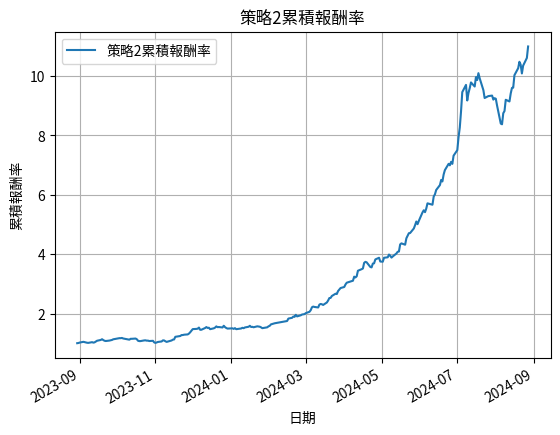

In [ ]:
fee_rate = 0.007

def keep_positive_scores(row):
    positive_scores = row[row > 0]
    return positive_scores
gpt_scores_filtered = gpt_scores.apply(keep_positive_scores, axis=1).fillna(0)

sMdf2 = sMdf.copy()
sMdf2[:] = 0
sMdf2.index = df_returns.index[1:]
sMdf2.update(gpt_scores_filtered)
sMdf2.fillna(0, inplace=True)

l_new = sMdf2.sum(axis=1)
sMdf2 = sMdf2.div(l_new, axis='index')

r2 = [1.0]
for i in range(0, len(sMdf2) - 1):
    p = []
    for t in df_returns.columns:
        s = df_returns[t]
        p.append(sMdf2[t][i] * r2[i] * (s[i + 2] / 100 - fee_rate + 1))
    r2.append(sum(p))

rdf2 = pd.DataFrame(r2, columns=['累積報酬率'])
rdf2.index = df_returns.index[1:]
rdf2['累積報酬率'].plot()
plt.title('策略2累積報酬率')
plt.xlabel('日期')
plt.ylabel('累積報酬率')
plt.legend(['策略2累積報酬率'])
plt.grid(True)
plt.show()

## 投資策略3：依ChatGPT得出之「風險評分倒數」作為權重投資

<ipython-input-11-b45f34e22d2f>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p.append(sMdf3[t][i] * r3[i] * (s[i + 2] / 100 - fee_rate + 1))


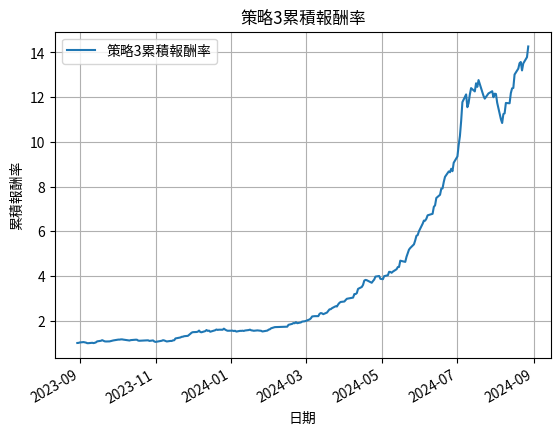

In [ ]:
fee_rate = 0.007

sMdf3 = sMdf.copy()
sMdf3[:] = 0
sMdf3.index = df_returns.index[1:]
sMdf3.update(gpt_scores)
sMdf3.fillna(0, inplace=True)

sMdf3_inverse = sMdf3.copy()
sMdf3_inverse[sMdf3_inverse > 0] = 1 / sMdf3_inverse[sMdf3_inverse > 0]
sMdf3 = sMdf3_inverse

l_new = sMdf3.sum(axis=1)
sMdf3 = sMdf3.div(l_new, axis='index')

r3 = [1.0]
for i in range(0, len(sMdf3) - 1):
    p = []
    for t in df_returns.columns:
        s = df_returns[t]
        p.append(sMdf3[t][i] * r3[i] * (s[i + 2] / 100 - fee_rate + 1))
    r3.append(sum(p))

rdf3 = pd.DataFrame(r3, columns=['累積報酬率'])
rdf3.index = df_returns.index[1:]
rdf3['累積報酬率'].plot()
plt.title('策略3累積報酬率')
plt.xlabel('日期')
plt.ylabel('累積報酬率')
plt.legend(['策略3累積報酬率'])
plt.grid(True)
plt.show()

## 投資策略4：只投資ChatGPT得出之「風險評分」較高的組別，並依「風險評分」作為權重投資

<ipython-input-12-e005a3ba8393>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p.append(sMdf4[t][i] * r4[i] * (s[i + 2] / 100 - fee_rate + 1))


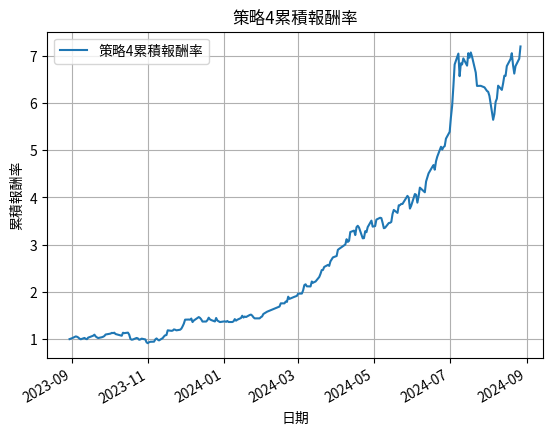

In [ ]:
fee_rate = 0.007

def filter_scores_by_max(row):
    max_value = row.max()
    min_value = max_value - 20
    filtered_row = row[(row >= min_value) & (row <= max_value)]
    return filtered_row
gpt_scores_filtered = gpt_scores.apply(filter_scores_by_max, axis=1).fillna(0)

sMdf4 = sMdf.copy()
sMdf4[:] = 0
sMdf4.index = df_returns.index[1:]
sMdf4.update(gpt_scores_filtered)
sMdf4.fillna(0, inplace=True)

l_new = sMdf4.sum(axis=1)
sMdf4 = sMdf4.div(l_new, axis='index')

r4 = [1.0]
for i in range(0, len(sMdf4) - 1):
    p = []
    for t in df_returns.columns:
        s = df_returns[t]
        p.append(sMdf4[t][i] * r4[i] * (s[i + 2] / 100 - fee_rate + 1))
    r4.append(sum(p))

rdf4 = pd.DataFrame(r4, columns=['累積報酬率'])
rdf4.index = df_returns.index[1:]
rdf4['累積報酬率'].plot()
plt.title('策略4累積報酬率')
plt.xlabel('日期')
plt.ylabel('累積報酬率')
plt.legend(['策略4累積報酬率'])
plt.grid(True)
plt.show()

## 投資策略5：只投資ChatGPT得出之「風險評分」較低的組別，並依「風險評分倒數」作為權重投資

<ipython-input-13-c9660addbea8>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p.append(sMdf5[t][i] * r5[i] * (s[i + 2] / 100 - fee_rate + 1))


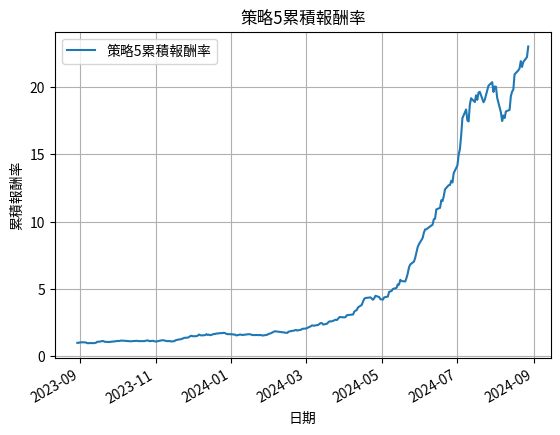

In [ ]:
fee_rate = 0.007

def filter_scores_by_min(row):
    positive_scores = row[row > 0]
    min_value = positive_scores.min()
    max_value = min_value + 20
    filtered_row = row[(row >= min_value) & (row <= max_value)]
    return filtered_row
gpt_scores_filtered = gpt_scores.apply(filter_scores_by_min, axis=1).fillna(0)

sMdf5 = sMdf.copy()
sMdf5[:] = 0
sMdf5.index = df_returns.index[1:]
sMdf5.update(gpt_scores_filtered)
sMdf5.fillna(0, inplace=True)

sMdf5_inverse = sMdf5.copy()
sMdf5_inverse[sMdf5_inverse > 0] = 1 / sMdf5_inverse[sMdf5_inverse > 0]
sMdf5 = sMdf5_inverse

l_new = sMdf5.sum(axis=1)
sMdf5 = sMdf5.div(l_new, axis='index')

r5 = [1.0]
for i in range(0, len(sMdf5) - 1):
    p = []
    for t in df_returns.columns:
        s = df_returns[t]
        p.append(sMdf5[t][i] * r5[i] * (s[i + 2] / 100 - fee_rate + 1))
    r5.append(sum(p))

rdf5 = pd.DataFrame(r5, columns=['累積報酬率'])
rdf5.index = df_returns.index[1:]
rdf5['累積報酬率'].plot()
plt.title('策略5累積報酬率')
plt.xlabel('日期')
plt.ylabel('累積報酬率')
plt.legend(['策略5累積報酬率'])
plt.grid(True)
plt.show()

# 策略比較

## 視覺化
繪製5個策略累積報酬率比較圖

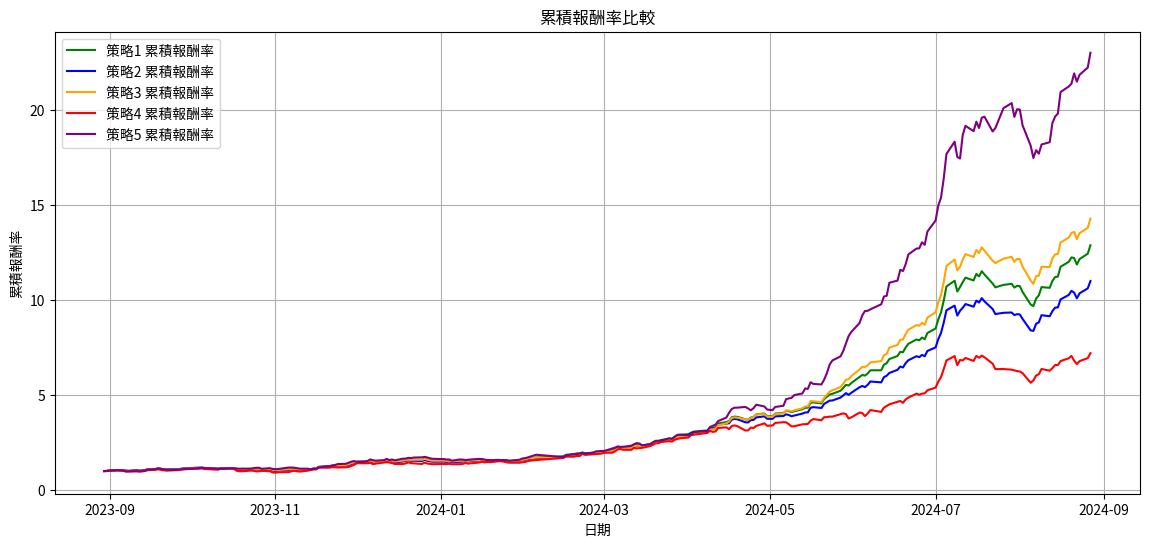

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(rdf1.index, rdf1['累積報酬率'], label='策略1 累積報酬率', color='g')
plt.plot(rdf2.index, rdf2['累積報酬率'], label='策略2 累積報酬率', color='b')
plt.plot(rdf3.index, rdf3['累積報酬率'], label='策略3 累積報酬率', color='orange')
plt.plot(rdf4.index, rdf4['累積報酬率'], label='策略4 累積報酬率', color='r')
plt.plot(rdf5.index, rdf5['累積報酬率'], label='策略5 累積報酬率', color='purple')

plt.title('累積報酬率比較')
plt.xlabel('日期')
plt.ylabel('累積報酬率')
plt.legend()
plt.grid(True)
plt.show()

取自然對數後再畫一次

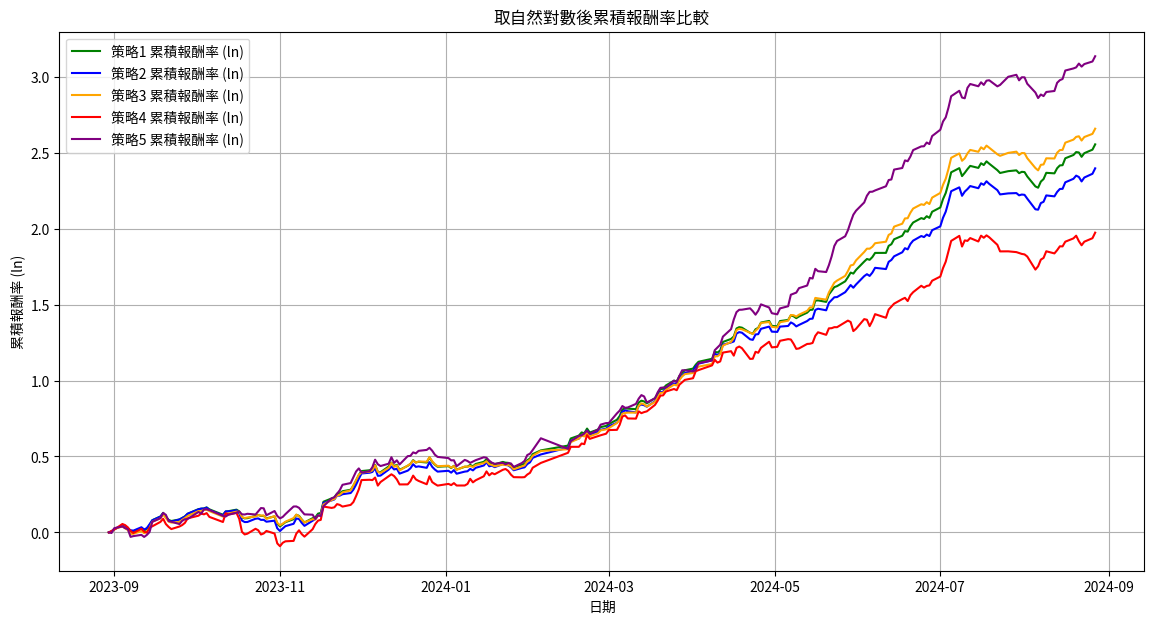

In [ ]:
rdf1_ln = np.log(rdf1['累積報酬率'])
rdf2_ln = np.log(rdf2['累積報酬率'])
rdf3_ln = np.log(rdf3['累積報酬率'])
rdf4_ln = np.log(rdf4['累積報酬率'])
rdf5_ln = np.log(rdf5['累積報酬率'])

df_ln = pd.DataFrame({
    '策略1 累積報酬率': rdf1_ln,
    '策略2 累積報酬率': rdf2_ln,
    '策略3 累積報酬率': rdf3_ln,
    '策略4 累積報酬率': rdf4_ln,
    '策略5 累積報酬率': rdf5_ln
})

plt.figure(figsize=(14, 7))
plt.plot(df_ln.index, df_ln['策略1 累積報酬率'], label='策略1 累積報酬率 (ln)', color='g')
plt.plot(df_ln.index, df_ln['策略2 累積報酬率'], label='策略2 累積報酬率 (ln)', color='b')
plt.plot(df_ln.index, df_ln['策略3 累積報酬率'], label='策略3 累積報酬率 (ln)', color='orange')
plt.plot(df_ln.index, df_ln['策略4 累積報酬率'], label='策略4 累積報酬率 (ln)', color='r')
plt.plot(df_ln.index, df_ln['策略5 累積報酬率'], label='策略5 累積報酬率 (ln)', color='purple')
plt.xlabel('日期')
plt.ylabel('累積報酬率 (ln)')
plt.title('取自然對數後累積報酬率比較')
plt.legend()
plt.grid(True)
plt.show()

與大盤比較

In [ ]:
market_data = rm.copy()
market_data = market_data[2:]
market_data['每日報酬率'] = market_data['收盤價(元)'].pct_change()
market_data['累積報酬率'] = (1 + market_data['每日報酬率']).cumprod()
market_data.at[market_data.index[0], '累積報酬率'] = 1
market_data['累積報酬率_ln'] = np.log(market_data['累積報酬率'])
display(market_data.head())

,開盤價(元),最高價(元),最低價(元),收盤價(元),每日報酬率,累積報酬率,累積報酬率_ln
年月日,,,,,,,
2023-08-30,16666.33,16780.42,16666.33,16719.82,NaN,1.000000,0.000000
2023-08-31,16707.35,16712.22,16630.67,16634.51,-0.005102,0.994898,-0.005115
2023-09-01,16640.92,16730.13,16619.23,16644.94,0.000627,0.995521,-0.004489
2023-09-04,16649.67,16789.69,16648.51,16789.69,0.008696,1.004179,0.004170
2023-09-05,16784.12,16791.61,16727.44,16791.61,0.000114,1.004294,0.004285


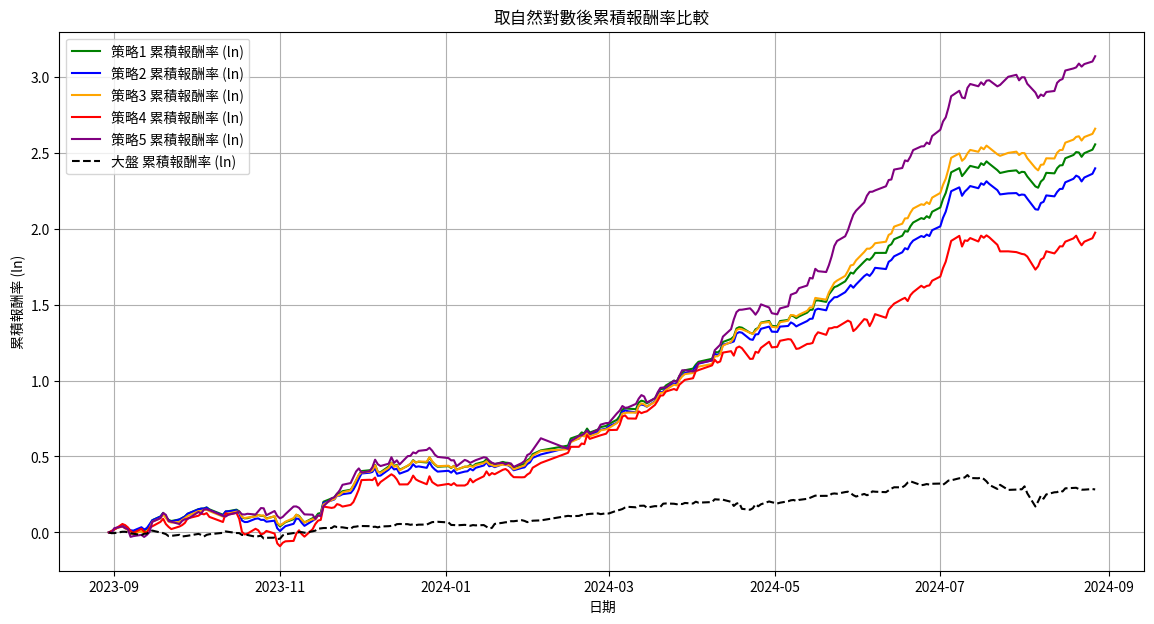

In [ ]:
rdf1_ln = np.log(rdf1['累積報酬率'])
rdf2_ln = np.log(rdf2['累積報酬率'])
rdf3_ln = np.log(rdf3['累積報酬率'])
rdf4_ln = np.log(rdf4['累積報酬率'])
rdf5_ln = np.log(rdf5['累積報酬率'])
rdf_market_ln = market_data['累積報酬率_ln']

df_ln = pd.DataFrame({
    '策略1 累積報酬率': rdf1_ln,
    '策略2 累積報酬率': rdf2_ln,
    '策略3 累積報酬率': rdf3_ln,
    '策略4 累積報酬率': rdf4_ln,
    '策略5 累積報酬率': rdf5_ln,
    '大盤 累積報酬率': rdf_market_ln
})

plt.figure(figsize=(14, 7))
plt.plot(df_ln.index, df_ln['策略1 累積報酬率'], label='策略1 累積報酬率 (ln)', color='g')
plt.plot(df_ln.index, df_ln['策略2 累積報酬率'], label='策略2 累積報酬率 (ln)', color='b')
plt.plot(df_ln.index, df_ln['策略3 累積報酬率'], label='策略3 累積報酬率 (ln)', color='orange')
plt.plot(df_ln.index, df_ln['策略4 累積報酬率'], label='策略4 累積報酬率 (ln)', color='r')
plt.plot(df_ln.index, df_ln['策略5 累積報酬率'], label='策略5 累積報酬率 (ln)', color='purple')
plt.plot(df_ln.index, df_ln['大盤 累積報酬率'], label='大盤 累積報酬率 (ln)', color='black', linestyle='--')

plt.xlabel('日期')
plt.ylabel('累積報酬率 (ln)')
plt.title('取自然對數後累積報酬率比較')
plt.legend()
plt.grid(True)
plt.show()

## 指標比較
列出各策略與大盤之標準差、最大回撤、夏普比率、索提諾比率

In [ ]:
def calculate_standard_deviation(returns):
    return np.std(returns)

def calculate_max_drawdown(returns):
    peak = returns.cummax()
    drawdown = (returns - peak) / peak
    return drawdown.min()

def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns.pct_change().fillna(0) - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

def calculate_sortino_ratio(returns, risk_free_rate):
    excess_returns = returns.pct_change().fillna(0) - risk_free_rate
    downside_returns = excess_returns[excess_returns < 0]
    downside_deviation = np.std(downside_returns)
    return np.mean(excess_returns) / downside_deviation

def prepare_risk_free_rate(rdf, rf):
    rdf['rf'] = rf['日利率'].reindex(rdf.index).ffill().bfill()
    return rdf

def calculate_metrics(returns, risk_free_rate):
    return {
        '標準差': calculate_standard_deviation(returns),
        '最大回撤': calculate_max_drawdown(returns),
        '夏普比率': calculate_sharpe_ratio(returns, risk_free_rate),
        '索提諾比率': calculate_sortino_ratio(returns, risk_free_rate)
    }
rdf_list = [rdf1, rdf2, rdf3, rdf4, rdf5]
rdf_list = [prepare_risk_free_rate(rdf, rf) for rdf in rdf_list]
metrics = {
    f'rdf{i+1}': calculate_metrics(rdf_list[i]['累積報酬率'], rdf_list[i]['rf'])
    for i in range(5)
}
market_data['rf'] = rf['日利率'].reindex(market_data.index).ffill().bfill()
metrics['大盤'] = calculate_metrics(market_data['累積報酬率'], market_data['rf'])
for name, metric in metrics.items():
    print(f"{name}:")
    for k, v in metric.items():
        print(f"  {k}: {v:.4f}")

rdf1:
  標準差: 3.5428
  最大回撤: -0.1593
  夏普比率: 0.4745
  索提諾比率: 0.8147
rdf2:
  標準差: 3.0178
  最大回撤: -0.1705
  夏普比率: 0.4337
  索提諾比率: 0.7369
rdf3:
  標準差: 3.9948
  最大回撤: -0.1505
  夏普比率: 0.4941
  索提諾比率: 0.8574
rdf4:
  標準差: 1.9702
  最大回撤: -0.2018
  夏普比率: 0.2968
  索提諾比率: 0.4769
rdf5:
  標準差: 6.5792
  最大回撤: -0.1419
  夏普比率: 0.4671
  索提諾比率: 0.9136
大盤:
  標準差: 0.1412
  最大回撤: -0.1869
  夏普比率: 0.0935
  索提諾比率: 0.1021


## 利用CAPM計算超額報酬α與風險係數β

### 策略與大盤比較

In [ ]:
rdf = market_data.copy()
rdf['rf'] = rf['日利率'].reindex(rdf.index).ffill().bfill()
rdf['股票市場溢價'] = rdf['每日報酬率'] - rdf['rf']

In [ ]:
rdf_list = [rdf1, rdf2, rdf3, rdf4, rdf5]
rdf_names = ['策略1', '策略2', '策略3', '策略4', '策略5']

c_results = {}

for rdfx, name in zip(rdf_list, rdf_names):
    rdfx['rf'] = rf['日利率'].reindex(rdfx.index).ffill().bfill()
    rdfx['每日報酬率'] = rdfx['累積報酬率'].pct_change().fillna(0)
    rdfx['超額報酬率'] = rdfx['每日報酬率'] - rdfx['rf']
    X = rdf['股票市場溢價'][1:]
    y = rdfx['超額報酬率'][1:]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    alpha = model.params['const']
    beta = model.params['股票市場溢價']

    c_results[name] = {
        'α（超額報酬）': alpha,
        'β（風險係數）': beta
    }
    print(f"Results for {name}:")
    print(model.summary())
    print("\n" + "-"*80 + "\n")

for name, metrics in c_results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print("\n" + "-"*80 + "\n")

Results for 策略1:
                            OLS Regression Results                            
Dep. Variable:                  超額報酬率   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     33.07
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           2.70e-08
Time:                        07:31:50   Log-Likelihood:                 585.98
No. Observations:                 241   AIC:                            -1168.
Df Residuals:                     239   BIC:                            -1161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.001   

### 不同策略比較

策略1 VS 策略4

In [ ]:
rdf1['每日報酬率'] = rdf1['累積報酬率'].pct_change().fillna(0)
rdf4['每日報酬率'] = rdf4['累積報酬率'].pct_change().fillna(0)
X = rdf1['每日報酬率'][1:]
y = rdf4['每日報酬率'][1:]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
alpha = model.params['const']
beta = model.params['每日報酬率']
print(f"α: {alpha:.4f}")
print(f"β: {beta:.4f}")

                            OLS Regression Results                            
Dep. Variable:                  每日報酬率   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     651.3
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           3.40e-70
Time:                        07:31:51   Log-Likelihood:                 672.84
No. Observations:                 241   AIC:                            -1342.
Df Residuals:                     239   BIC:                            -1335.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.001     -2.952      0.0

策略1 VS 策略5

In [ ]:
rdf1['每日報酬率'] = rdf1['累積報酬率'].pct_change().fillna(0)
rdf5['每日報酬率'] = rdf5['累積報酬率'].pct_change().fillna(0)
X = rdf1['每日報酬率'][1:]
y = rdf5['每日報酬率'][1:]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
alpha = model.params['const']
beta = model.params['每日報酬率']
print(f"α: {alpha:.4f}")
print(f"β: {beta:.4f}")

                            OLS Regression Results                            
Dep. Variable:                  每日報酬率   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     303.4
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           2.02e-44
Time:                        07:31:51   Log-Likelihood:                 613.61
No. Observations:                 241   AIC:                            -1223.
Df Residuals:                     239   BIC:                            -1216.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.366      0.0

策略4 VS 策略5

In [ ]:
rdf4['每日報酬率'] = rdf4['累積報酬率'].pct_change().fillna(0)
rdf5['每日報酬率'] = rdf5['累積報酬率'].pct_change().fillna(0)
X = rdf4['每日報酬率'][1:]
y = rdf5['每日報酬率'][1:]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
alpha = model.params['const']
beta = model.params['每日報酬率']
print(f"α: {alpha:.4f}")
print(f"β: {beta:.4f}")

                            OLS Regression Results                            
Dep. Variable:                  每日報酬率   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     37.99
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           2.99e-09
Time:                        07:31:51   Log-Likelihood:                 532.63
No. Observations:                 241   AIC:                            -1061.
Df Residuals:                     239   BIC:                            -1054.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0103      0.002      5.748      0.0